In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import gdal
import osgeo.gdalnumeric as gdn

## Utility functions

In [16]:
def plot_image(image, factor=1, filename=None):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    plt.xticks([])
    plt.yticks([])
        
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        
def plot_image_labels(image, labels, factor=1, filename=None):

    # setting 0 values to NaN for transparent plotting
    labels_nan = labels.astype('float')
    labels_nan[labels_nan == 0] = np.nan
    
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    plt.xticks([])
    plt.yticks([])
        
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
        plt.imshow(labels_nan, cmap='viridis_r', alpha=1)
    else:
        plt.imshow(image)
        plt.imshow(labels_nan, cmap='viridis_r', alpha=1)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')

In [17]:
# Function to load multi-spectral raster to numpy array
# https://gis.stackexchange.com/questions/32995/fully-load-raster-into-a-numpy-array

def img_to_array(input_file, dim_ordering="channels_last", dtype='float32'):
    file  = gdal.Open(input_file)
    bands = [file.GetRasterBand(i) for i in range(1, file.RasterCount + 1)]
    arr = np.array([gdn.BandReadAsArray(band) for band in bands]).astype(dtype)
    if dim_ordering == "channels_last":
        arr = np.transpose(arr, [1, 2, 0])  # Reorders dimensions, so that channels are last
    return arr

## Loading 2017 Satellite Images

In [19]:
YEAR = 2017
data_directory = './data/processed/'
img_directory = os.path.join(data_directory, str(YEAR), 'images')

imgs = [f for f in os.listdir(img_directory)] 
imgs

['2017_08_23.tif', '2017_06_09.tif', '2017_05_13.tif', '2017_07_19.tif']

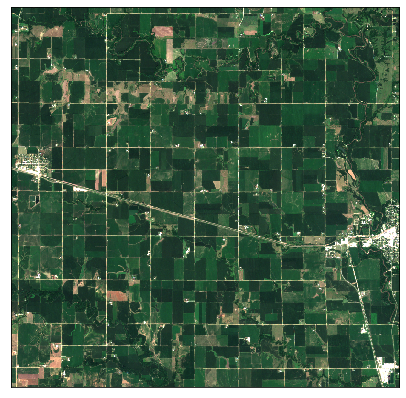

In [20]:
img_path = os.path.join(img_directory,'2017_07_19.tif')
img_2017_07_19 = img_to_array(img_path)

plot_image(img_2017_07_19[:,:,[3,2,1]], 5)

## Loading 2017 Labels

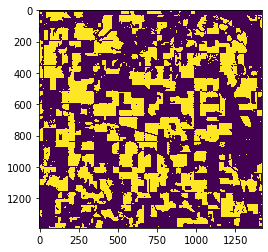

In [21]:
from PIL import Image

label_directory = os.path.join(data_directory, str(YEAR), 'labels', 'CDL_' + str(2017) + '.tif')

img_labels = Image.open(label_directory)
labels = np.asarray(img_labels)
plt.imshow(labels)

Percentage of corn crop pixels: 39.49


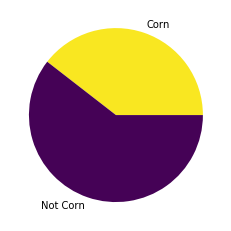

In [29]:
print('Percentage of corn crop pixels: %.2f' % 
      (np.count_nonzero(labels) / labels.size*100))

corn = np.count_nonzero(labels)
not_corn = labels.size - corn
class_ratio = [corn, not_corn]

plt.pie(class_ratio, labels=['Corn', 'Not Corn'], \
        colors = [(0.976, 0.906, 0.129),(0.271, 0.008, 0.337)])

plt.show()
# plt.savefig('pie_chart', bbox_inches='tight')

## Data Preparation for Training

### Reshape Data

In [32]:
def reshape_img(img):

    h = img.shape[0]
    w = img.shape[1]
    ch = img.shape[2]

    img_reshaped = img.reshape(h * w, ch)
    
    return img_reshaped

def reshape_labels(labels):
    h = labels.shape[0]
    w = labels.shape[1]
    
    labels_reshaped = labels.reshape(h * w)
    
    return labels_reshaped

In [40]:
img_2017_07_19_reshaped = reshape_img(img_2017_07_19)
labels_reshaped = reshape_labels(labels)

data = np.c_[img_2017_07_19_reshaped, labels_reshaped]
# np.random.shuffle(data)

In [42]:
from sklearn.model_selection import train_test_split

X = data[:,:-1]
y = data[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Standardizing features
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)  

In [47]:
# Training Logistic Regression
logmodel = LogisticRegression(solver='lbfgs')
logmodel.fit(X_train_scaled, y_train)

# Testing 
scaler = StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)  

y_pred = logmodel.predict(X_test_scaled)

### Results

In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report:\n', classification_report(y_test, y_pred))

Accuracy: 0.94
Confusion Matrix: 
 [[341651  16471]
 [ 21908 212110]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.95    358122
         1.0       0.93      0.91      0.92    234018

    accuracy                           0.94    592140
   macro avg       0.93      0.93      0.93    592140
weighted avg       0.94      0.94      0.94    592140



## Predicting on 2018 data

In [56]:
img_directory = os.path.join(data_directory, str(2018), 'images')


img_2018_07_12 = os.path.join(img_directory,'2018_07_12.tif')
img_2018 = img_to_array(img_2018_07_12)

img_2018_reshaped = reshape_img(img_2018)

scaler = StandardScaler().fit(img_2018_reshaped)
img_2018_scaled = scaler.transform(img_2018_reshaped)

y_2018_pred = logmodel.predict(img_2018_scaled).reshape(1390,1420)

In [57]:
label_2018 = os.path.join(data_directory, str(2018), 'labels', 'CDL_2018.tif')

labels_2018 = Image.open(label_2018)
labels_2018 = np.array(labels_2018)

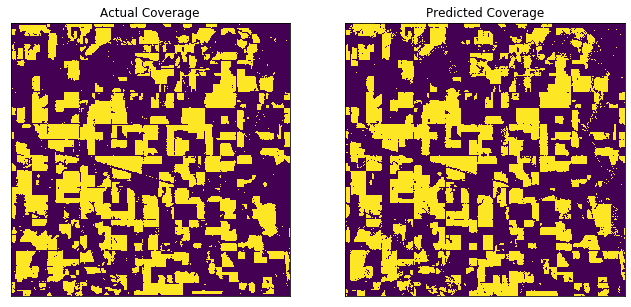

In [58]:
f = plt.figure(figsize=(11,6))

plt.subplot(121)
plt.title('Actual Coverage')
plt.xticks([])
plt.yticks([])
plt.imshow(labels_2018)

plt.subplot(122)
plt.title('Predicted Coverage')
plt.xticks([])
plt.yticks([])
plt.imshow(y_2018_pred)

In [60]:
print('Accuracy: %.2f' % accuracy_score(labels_2018.flatten(), y_2018_pred.flatten()))
print('Confusion Matrix: \n', confusion_matrix(labels_2018.flatten(), y_2018_pred.flatten()))
print('Classification report:\n', classification_report(labels_2018.flatten(), y_2018_pred.flatten()))

Accuracy: 0.94
Confusion Matrix: 
 [[1129792   64840]
 [  62166  717002]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95   1194632
           1       0.92      0.92      0.92    779168

    accuracy                           0.94   1973800
   macro avg       0.93      0.93      0.93   1973800
weighted avg       0.94      0.94      0.94   1973800



## Plotting predicted labels over region

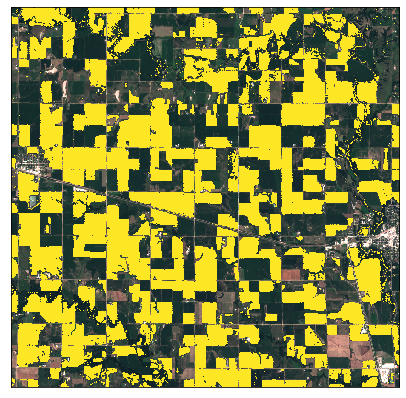

In [66]:
plot_image_labels(img_2018[:,:,[3,2,1]], labels=y_2018_pred, factor=5)

## Prediction Accuracy over Time

In [69]:
data_2018_directory = './data/processed/' + str(2018) 
img_2018_directory = os.path.join(data_2018_directory, 'images')

imgs_2018 = [f for f in os.listdir(img_2018_directory)]
imgs_2018 = sorted(imgs_2018)

results = {}

for i in imgs_2018:
    path = os.path.join(img_2018_directory, i)
    img = img_to_array(path)
    
    img_date = (i.split('.')[:-1][0])
    
    img_reshape = img.reshape(1390*1420, 13)

    scaler = StandardScaler().fit(img_reshape)
    img_scaled = scaler.transform(img_reshape)
    y_pred = logmodel.predict(img_scaled).reshape(1390,1420)
        
    accuracy = accuracy_score(y_2018_labels.flatten(), y_pred.flatten())
    
    print(img_date, "Accuracy: %.2f" % accuracy)

    results[img_date] = accuracy

2018_04_23 Accuracy: 0.58
2018_04_28 Accuracy: 0.61
2018_05_25 Accuracy: 0.56
2018_06_02 Accuracy: 0.60
2018_06_27 Accuracy: 0.87
2018_07_02 Accuracy: 0.90
2018_07_04 Accuracy: 0.92
2018_07_07 Accuracy: 0.93
2018_07_09 Accuracy: 0.93
2018_07_12 Accuracy: 0.94
2018_07_19 Accuracy: 0.91
2018_07_24 Accuracy: 0.90
2018_08_01 Accuracy: 0.91
2018_08_03 Accuracy: 0.88
2018_08_06 Accuracy: 0.89
2018_08_08 Accuracy: 0.91
2018_08_11 Accuracy: 0.89


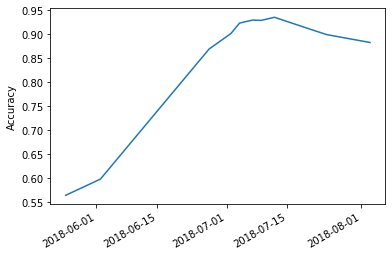

In [841]:
import datetime

img_2018_dates = list(results.keys())
img_2018_acc = list(results.values())

img_2018 = [datetime.datetime.strptime(d, "%Y_%m_%d").date() for d in img_2018_dates]

plt.plot(img_2018, img_2018_acc)
plt.gcf().autofmt_xdate() # beautify the x-labels

plt.ylabel('Accuracy')

# plt.savefig('accuracy_over_time', bbox_inches='tight')

## Removing salt-and-pepper noise
Attempting image post-processing techniques to remove noise

Accuracy before filter: 0.93565
Accuracy after filter: 0.94150


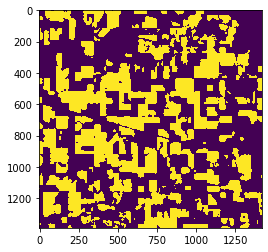

In [71]:
from scipy import ndimage

y_pred_closed = ndimage.median_filter(y_2018_pred, size=10).astype(int)
plt.imshow(y_pred_closed)
print("Accuracy before filter: %.5f" % accuracy_score(y_2018_labels.flatten(), y_2018_pred.flatten()))
print("Accuracy after filter: %.5f" % accuracy_score(y_2018_labels.flatten(), y_pred_closed.flatten()))